In [1]:
%matplotlib inline
# Import dataset libraries and util functions
from pathlib import Path
from tempfile import TemporaryDirectory
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from concrete import fhe
from concrete.ml.deployment import FHEModelClient, FHEModelDev, FHEModelServer
from sklearn.feature_selection import SelectKBest, f_classif
from concrete.ml.sklearn import SGDClassifier
from concrete.compiler import check_gpu_available
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from concrete.compiler import check_gpu_available
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from sklearn import datasets
from sklearn.linear_model import SGDClassifier as SklearnSGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from concrete import fhe
from concrete.ml.deployment import FHEModelClient, FHEModelDev, FHEModelServer
from concrete.ml.sklearn import SGDClassifier
from client import Client

use_gpu_if_available = False
device = "cuda" if use_gpu_if_available and check_gpu_available() else "cpu"

In [8]:
class Server:
    def __init__(self):
        self.models = {}
    
    def recieve_encrypted_data(self, condition, data):
        x = data.iloc[:, :-1].copy()
        y = data.iloc[:, -1].copy().squeeze()
        for column in x.select_dtypes(include=['object']).columns:
            x[column] = LabelEncoder().fit_transform(x[column])
        if y.dtype == 'object':
            y = LabelEncoder().fit_transform(y)
        pca = PCA(n_components=2)
        x_pca = pca.fit_transform(x)
        x_scaled = MinMaxScaler(feature_range=[-5, 5]).fit_transform(x_pca)
        x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)
        
        #eventually make this check firebase
        if condition not in self.models:
            parameters_range = (-5, 5)
            model = SGDClassifier(
                random_state=42,  # Or any fixed seed
                max_iter=50,  # Based on the notebook's parameter
                fit_encrypted=True,
                parameters_range=parameters_range,
                verbose=True
            )
            model.fit(x_train, y_train, fhe="execute", device="cpu")
            y_pred = model.predict(x_test)
            accuracy = accuracy_score(y_test, y_pred)
            print(accuracy)
            self.plot_predictions(x_test, y_test, y_pred)

        
        
    def send_model(self, condition):
        return self.models[condition]
        
    def plot_predictions(self, x_test, y_test, y_pred):
        x_min, x_max = x_test[:, 0].min() - 0.5, x_test[:, 0].max() + 0.5
        y_min, y_max = x_test[:, 1].min() - 0.5, x_test[:, 1].max() + 0.5
        
        # Plot each test data point with actual and predicted colors
        for idx, point in enumerate(x_test):
            print(idx, point)
            actual_color = 'blue' if y_test.to_numpy()[idx] == 1 else 'red'  # Actual class
            predicted_edgecolor = 'blue' if y_pred[idx] == 1 else 'red'  # Predicted class
            marker = 'x' if actual_color == predicted_edgecolor else 'o'
            plt.scatter(point[0], point[1], color=actual_color, edgecolor=predicted_edgecolor, marker=marker, s=50, alpha=0.6)
    
        # Set plot labels and title
            
        # Labels and legend
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.title("Decision Boundary and Actual Points")
        plt.legend(loc="upper right")
        plt.show()

# Call the function to plot


Compiling training circuit on device 'cpu'...
Compilation took 4.2578 seconds.
Key Generation...
Key generation took 46.5612 seconds.
Training on encrypted data...
Iteration 0 took 17.36 seconds.
Iteration 1 took 14.28 seconds.
Iteration 2 took 10.94 seconds.
Iteration 3 took 11.22 seconds.
Iteration 4 took 9.68 seconds.
Iteration 5 took 10.08 seconds.
Iteration 6 took 11.42 seconds.
Iteration 7 took 10.07 seconds.
Iteration 8 took 8.94 seconds.
Iteration 9 took 10.78 seconds.
Iteration 10 took 12.09 seconds.
Iteration 11 took 9.57 seconds.
Iteration 12 took 7.51 seconds.
Iteration 13 took 8.54 seconds.
Iteration 14 took 7.82 seconds.
Iteration 15 took 7.28 seconds.
Iteration 16 took 8.10 seconds.
Iteration 17 took 7.70 seconds.
Iteration 18 took 9.26 seconds.
Iteration 19 took 7.57 seconds.
Iteration 20 took 8.41 seconds.
Iteration 21 took 9.46 seconds.
Iteration 22 took 7.71 seconds.
Iteration 23 took 9.67 seconds.
Iteration 24 took 11.66 seconds.
Iteration 25 took 10.37 seconds.
Ite

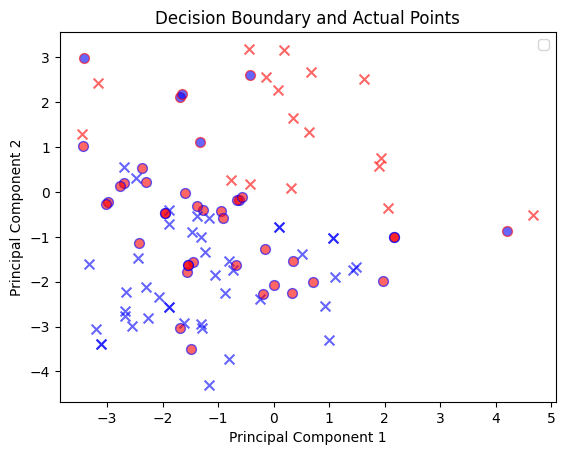

In [9]:
if __name__ == "__main__":
    c1 = Client() 
    c1.upload_data("heart disease", "../data/heart_data_1.csv")
    s = Server()
    data = c1.send_encrypted_data("heart disease")
    s.recieve_encrypted_data("heart disease", data)